# Loading libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from keras_tuner import Hyperband

# Loading the training dataset

In [7]:
file_path = os.path.join(os.getcwd(), '..', 'data', 'training_data.csv')

try:
	df = pd.read_csv(file_path)
	display(df)
except FileNotFoundError:
	print("Error: 'loan_data.csv' not found. Please ensure the file is in the correct location.")
except Exception as e:
	print(f"An error occurred: {e}")

,person_gender,person_education,person_emp_exp,person_home_ownership,loan_intent,loan_int_rate,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,income_credit_interaction,loan_amnt_int_rate,debt_to_income,log_person_income,log_loan_amnt,log_loan_percent_income,age_18-24,age_25-34,age_35-49,age_50+
0,female,Master,0.0,RENT,PERSONAL,16.02,3.0,561,No,1,40362828.0,560700.00,0.486462,11.183713,10.463132,0.398776,1,0,0,0
1,female,High School,0.0,OWN,EDUCATION,11.14,2.0,504,Yes,0,6190128.0,11140.00,0.081420,9.415971,6.908755,0.076961,1,0,0,0
2,female,High School,3.0,MORTGAGE,MEDICAL,12.87,3.0,635,No,1,7898130.0,70785.00,0.442193,9.428592,8.612685,0.364643,1,0,0,0
3,female,Bachelor,0.0,RENT,MEDICAL,15.23,2.0,675,No,1,53833275.0,533050.00,0.438855,11.286702,10.463132,0.364643,1,0,0,0
4,male,Master,1.0,RENT,MEDICAL,14.27,4.0,586,No,1,38755110.0,499450.00,0.529221,11.099469,10.463132,0.425268,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,male,Associate,6.0,RENT,MEDICAL,15.66,3.0,645,No,1,30941295.0,234900.00,0.312689,10.778373,9.615872,0.270027,0,1,0,0
44996,female,Associate,17.0,RENT,HOMEIMPROVEMENT,14.07,11.0,621,No,1,40861800.0,126630.00,0.136778,11.094390,9.105091,0.131028,0,0,1,0
44997,male,Associate,7.0,RENT,DEBTCONSOLIDATION,10.02,10.0,668,No,1,38037256.0,27765.42,0.048664,10.949806,7.927324,0.048790,0,1,0,0
44998,male,Bachelor,4.0,RENT,EDUCATION,13.23,6.0,604,No,1,20031056.0,158760.00,0.361838,10.409250,9.392745,0.307485,0,1,0,0


# One Hot Encoding the Categorical Features

In [9]:
# Identify categorical columns
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded categorical features with numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
processed_df = pd.concat([df[numerical_cols], encoded_df], axis=1)

# Display the first few rows of the updated DataFrame
display(processed_df.head())

,person_emp_exp,loan_int_rate,cb_person_cred_hist_length,credit_score,loan_status,income_credit_interaction,loan_amnt_int_rate,debt_to_income,log_person_income,log_loan_amnt,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
0,0.0,16.02,3.0,561,1,40362828.0,560700.0,0.486462,11.183713,10.463132,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,11.14,2.0,504,0,6190128.0,11140.0,0.081420,9.415971,6.908755,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,12.87,3.0,635,1,7898130.0,70785.0,0.442193,9.428592,8.612685,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,15.23,2.0,675,1,53833275.0,533050.0,0.438855,11.286702,10.463132,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,14.27,4.0,586,1,38755110.0,499450.0,0.529221,11.099469,10.463132,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Spliting the training data

In [24]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = processed_df.drop('loan_status', axis=1)
y = processed_df['loan_status']

# Split data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [25]:
# Split data into test and val sets
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Feature scaling

In [26]:
numerical_cols = ['person_emp_exp', 'loan_int_rate', 'cb_person_cred_hist_length', 'credit_score', 'income_credit_interaction', 'loan_amnt_int_rate', 'log_person_income', 'log_loan_amnt', 'log_loan_percent_income']

# 1. Create the StandardScaler object
scaler = StandardScaler()

# 2. Fit the scaler on the training data (numerical features only)
scaler.fit(X_train[numerical_cols])

# 3. Transform all three datasets using the fitted scaler
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])

In [27]:
print(f"Original training data size: {X.shape}")
print(f"New training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Test data size: {X_test.shape}")
print(f"Original training data size (target var): {y.shape}")
print(f"New training data size (target var): {y_train.shape}")
print(f"Validation data size (target var): {y_val.shape}")
print(f"Test data size (target var): {y_test.shape}")

Original training data size: (45000, 33)
New training data size: (27000, 33)
Validation data size: (9000, 33)
Test data size: (9000, 33)
Original training data size (target var): (45000,)
New training data size (target var): (27000,)
Validation data size (target var): (9000,)
Test data size (target var): (9000,)


# Basic Neural Network

In [28]:
# Custom helper function to plot the training history.

def plot_training_history(history, title):
    """Plots training & validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

Neural Network code

In [29]:
def build_basic_nn_model(input_shape):

    model = keras.Sequential(name="Basic_Loan_Approval_NN")
    model.add(layers.Input(shape=input_shape, name="Input_Layer"))
    model.add(layers.Dense(128, activation='relu', name='Hidden_Layer_1'))
    model.add(layers.Dense(32, activation='relu', name='Hidden_Layer_2'))
    model.add(layers.Dense(16, activation='relu', name='Hidden_Layer_3'))
    model.add(layers.Dense(1, activation='sigmoid', name='Output_Layer'))

    print("--- Basic Model Summary ---")
    model.summary()
    return model

input_shape = (X_train.shape[1],)

In [31]:
epochs = 50
batch_size = 64

print("\n--- Training with Adam Optimizer ---")
model_adam = build_basic_nn_model(input_shape)
model_adam.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_adam = model_adam.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=1
)


--- Training with Adam Optimizer ---
--- Basic Model Summary ---


Model: "Basic_Loan_Approval_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,025 (35.25 KB)

 Trainable params: 9,025 (35.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8639 - loss: 0.3195 - val_accuracy: 0.9168 - val_loss: 0.1919
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9076 - loss: 0.2015 - val_accuracy: 0.9177 - val_loss: 0.1884
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.1866 - val_accuracy: 0.9201 - val_loss: 0.1779
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9198 - loss: 0.1814 - val_accuracy: 0.9227 - val_loss: 0.1762
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9180 - loss: 0.1777 - val_accuracy: 0.9193 - val_loss: 0.1775
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9222 - loss: 0.1771 - val_accuracy: 0.9187 - val_loss: 0.1804
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9225 - loss: 0.1750 - val_accuracy: 0.9221 - val_loss: 0.1745
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9247 - loss: 0.1698 - val_accuracy: 0.


--- Best Model Training History ---


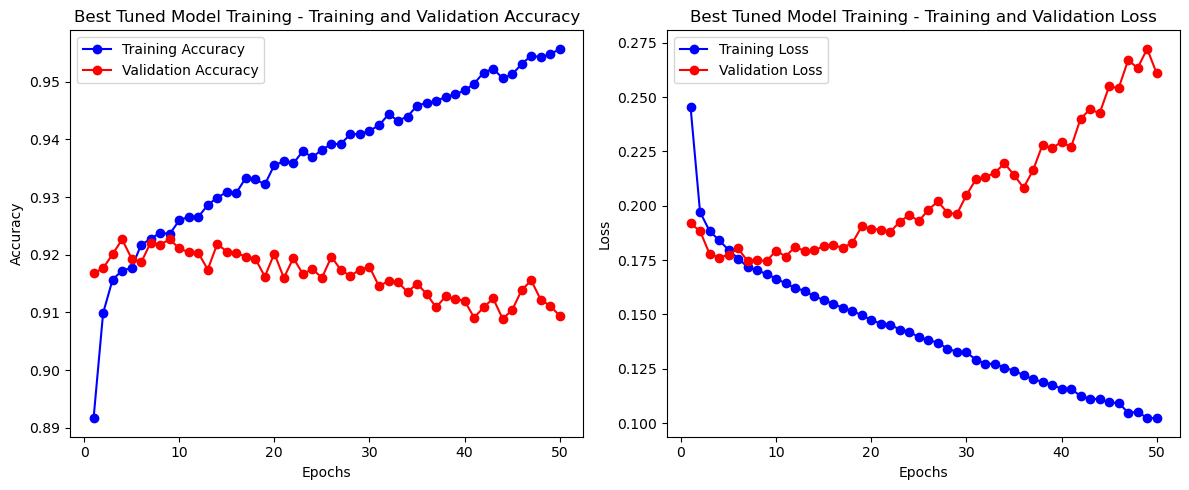

In [32]:
# Plot training history for the best model
print("\n--- Best Model Training History ---")
plot_training_history(history_adam, "Best Tuned Model Training")


--- Evaluating Model on Test Set ---
Test Loss: 0.2903
Test Accuracy: 0.9012
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6939
           1       0.80      0.75      0.78      2061

    accuracy                           0.90      9000
   macro avg       0.87      0.85      0.86      9000
weighted avg       0.90      0.90      0.90      9000


--- Confusion Matrix ---


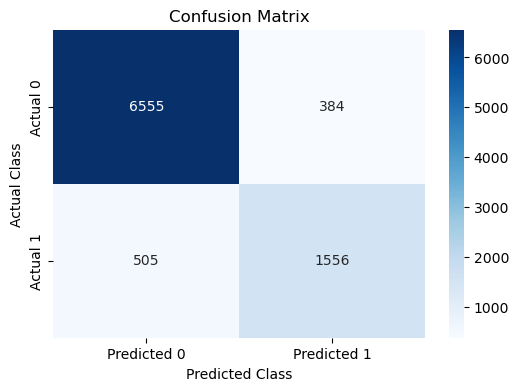

In [33]:
#Model Evaluation

print("\n--- Evaluating Model on Test Set ---")
test_loss, test_accuracy = model_adam.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


y_pred_proba = model_adam.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten() #threshold = 0.5

# Confusion Matrix
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_classes))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Hyperparameter Tuning using Keras Hyperband

In [34]:
#Calculating class weights for imbalanced classes

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
class_weights_calculated = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weight_dict = dict(enumerate(class_weights_calculated))

print(f"Calculated Class Weights: {class_weight_dict}")

Calculated Class Weights: {0: np.float64(0.6428571428571429), 1: np.float64(2.25)}


Neural Network architecture with varioud hyperparameter values

In [35]:
def build_tuned_model(hp, input_shape):

    model = Sequential(name="Tunable_Loan_Approval_NN")
    model.add(layers.Input(shape=input_shape, name="Input_Layer"))

    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])


    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32),
                    activation=activation_choice, name='Hidden_Layer_1'))
    model.add(LayerNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))


    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=192, step=32),
                    activation=activation_choice, name='Hidden_Layer_2'))
    model.add(LayerNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))


    model.add(Dense(units=hp.Int('units_3', min_value=16, max_value=128, step=16),
                    activation=activation_choice, name='Hidden_Layer_3'))
    model.add(LayerNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Optional: Add a fourth hidden layer controlled by a boolean hyperparameter
    if hp.Boolean("add_fourth_layer"):
        model.add(Dense(units=hp.Int('units_4', min_value=16, max_value=80, step=16),
                        activation=activation_choice, name='Hidden_Layer_4'))
        model.add(LayerNormalization())
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.1, max_value=0.4, step=0.1)))

    model.add(Dense(1, activation='sigmoid', name='Output_Layer'))

    # Learning rate range
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(name='recall')] # Add Recall metric
    )

    return model

In [36]:
input_shape = (X_train.shape[1],)

tuner = Hyperband(
    # Pass the modified build function
    lambda hp: build_tuned_model(hp, input_shape),
    objective='val_accuracy', # Optimize for objective='val_accuracy' or objective='val_recall' (good for class imbalanced datasets) or objective='val_loss' 
    max_epochs=50, # Max resources
    factor=3, #Reduction factor
    directory='hyperband_tuning_weighted',
    project_name='loan_approv_classification',
    overwrite=True
)

In [37]:
# Running the Hyperparameter 

search_early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss for early stopping to prevent overfitting
    patience=5, # Patience during search
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

search_batch_size = 128 #Manually defining batch size, can make it into a hyper parameter later

print("\n--- Starting Hyperparameter Search with Class Weights ---")
tuner.search(
    X_train, y_train,
    epochs=50, # max_epochs in tuner
    batch_size=search_batch_size,
    validation_data=(X_val, y_val), # Use the correct validation set
    callbacks=[search_early_stopping],
    class_weight=class_weight_dict # Pass the class weights here
)

Trial 90 Complete [00h 00m 25s]
val_accuracy: 0.9011111259460449

Best val_accuracy So Far: 0.9190000295639038
Total elapsed time: 00h 11m 05s


In [38]:
# Retrieving and Training the Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters Found:")
for param, value in best_hps.values.items():
    # Don't print tuner internal details unless needed
    if not param.startswith('tuner/'):
        print(f"- {param}: {value}")

Best Hyperparameters Found:
- activation: relu
- units_1: 224
- dropout_1: 0.4
- units_2: 96
- dropout_2: 0.4
- units_3: 112
- dropout_3: 0.4
- add_fourth_layer: False
- lr: 0.009698300460336732
- units_4: 16
- dropout_4: 0.4


In [23]:
# SAVE THE TRAINED BEST MODEL in .keras format. Prevents running the tuner again (saves time)
model_save_path = 'best_loan_approval_model_2.keras'
print(f"\n--- Saving the best trained model to {model_save_path} ---")
best_model = tuner.hypermodel.build(best_hps)
best_model.save(model_save_path)
print("Model saved successfully.")


--- Saving the best trained model to best_loan_approval_model_2.keras ---
Model saved successfully.


In [3]:
import warnings
# LOAD THE SAVED MODEL
warnings.filterwarnings('ignore')
model_load_path = 'best_loan_approval_model_2.keras'
print(f"\n--- Loading the saved model from {model_load_path} ---")
best_model = tf.keras.models.load_model(model_load_path)
print("Model loaded successfully.")
best_model.summary()


--- Loading the saved model from best_loan_approval_model_2.keras ---
Model loaded successfully.


Model: "Tunable_Loan_Approval_NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 224)            │         8,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 224)            │           448 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_3 (Dense)          │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_4 (Dense)          │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,973 (288.96 KB)

 Trainable params: 24,657 (96.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,316 (192.64 KB)

In [58]:
# Training best model on the full training data with class weights and early stopping
best_model = tuner.hypermodel.build(best_hps)
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8, # Can use slightly more patience for final training
    min_delta=0.001, # Adjust min_delta if needed
    restore_best_weights=True,
    verbose=1
)

# Train the best model on the full training data, validating on the validation set
print("\n--- Training Best Model with Class Weights ---")
history = best_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=search_batch_size, # hardcoded to 128
    validation_data=(X_val, y_val),
    callbacks=[final_early_stopping],
    class_weight=class_weight_dict
)


--- Training Best Model with Class Weights ---
Epoch 1/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8187 - loss: 0.3689 - recall: 0.8555 - val_accuracy: 0.8750 - val_loss: 0.2472 - val_recall: 0.9206
Epoch 2/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8713 - loss: 0.2501 - recall: 0.9163 - val_accuracy: 0.8781 - val_loss: 0.2379 - val_recall: 0.9242
Epoch 3/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8705 - loss: 0.2461 - recall: 0.9142 - val_accuracy: 0.8982 - val_loss: 0.2156 - val_recall: 0.8912
Epoch 4/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8745 - loss: 0.2446 - recall: 0.8973 - val_accuracy: 0.8766 - val_loss: 0.2391 - val_recall: 0.9257
Epoch 5/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.2356 - recall: 0.9047 - val_accuracy: 0.8677 - val_loss: 0.2517 - val_recall: 0.9309
Epoch 6/150
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8787 - loss: 0.2305 - recall: 0.9157 - val_accurac


--- Best Model Training History ---


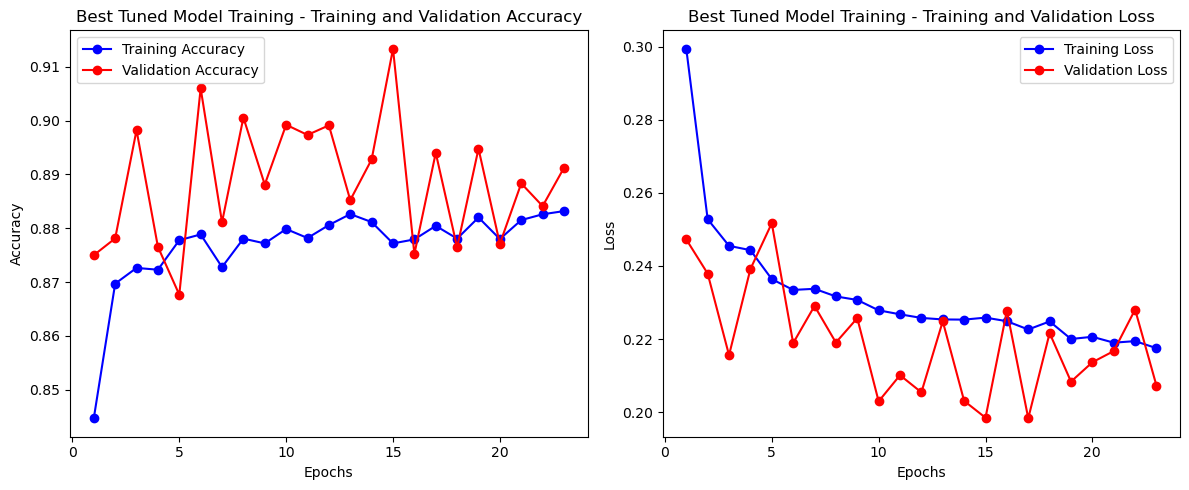

In [59]:
# Plot training history for the best model
print("\n--- Best Model Training History ---")
plot_training_history(history, "Best Tuned Model Training")


--- Evaluating Best Tuned Model on Test Set ---
Test Loss: 0.2105
Test Accuracy: 0.9028
Test Recall: 0.8661
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step

--- Best Model Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6939
           1       0.79      0.84      0.81      2061

    accuracy                           0.91      9000
   macro avg       0.87      0.88      0.88      9000
weighted avg       0.91      0.91      0.91      9000


--- Best Model Confusion Matrix (Test Set) ---


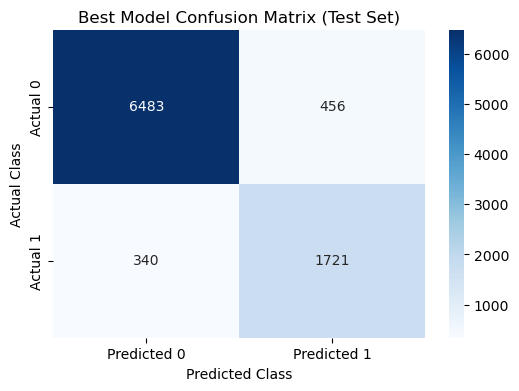

In [20]:
#Evaluating the Best Model on the Test Set

print("\n--- Evaluating Best Tuned Model on Test Set ---")
test_loss, test_accuracy, test_recall = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")

y_pred_proba_best = best_model.predict(X_test)
# Consider adjusting the threshold based on validation PR curve if needed
y_pred_classes_best = (y_pred_proba_best > 0.55).astype(int).flatten()

print("\n--- Best Model Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred_classes_best))

print("\n--- Best Model Confusion Matrix (Test Set) ---")
cm_best = confusion_matrix(y_test, y_pred_classes_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Best Model Confusion Matrix (Test Set)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

Plotting the AUC-ROC and PR-AUC curves

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
AUC-ROC Score: 0.9665


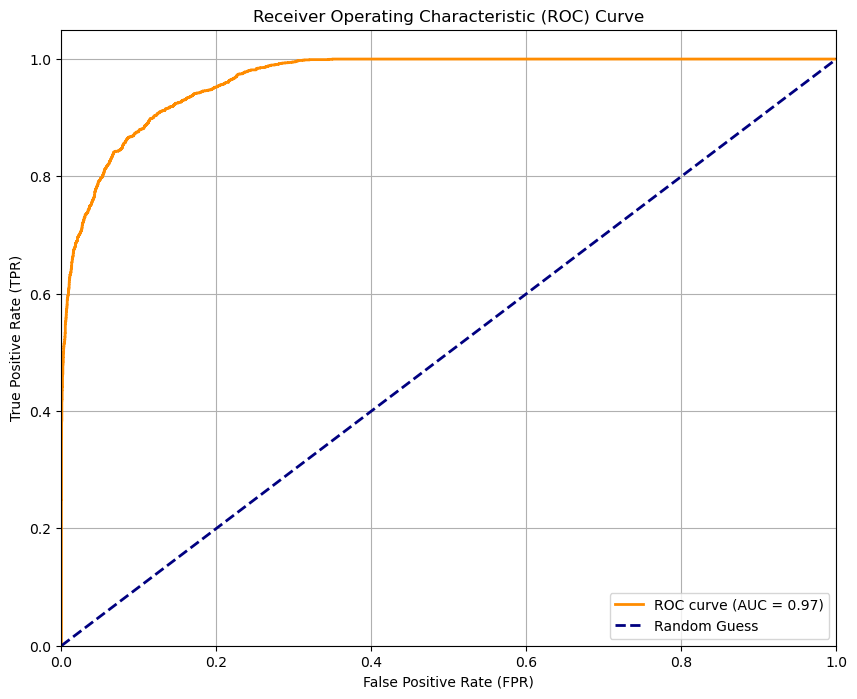

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Define the path to save the image
output_path = os.path.join(os.getcwd(), '..', 'images', 'AUC-ROC.png')

model_to_plot = best_model
y_pred_proba = model_to_plot.predict(X_test).ravel() # .ravel() flattens the array if needed
#Calculate ROC Curve Metrics
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC-ROC Score: {roc_auc:.4f}")
#Plot AUC-ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
# Save the plot
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Precision-Recall AUC (Average Precision): 0.9106


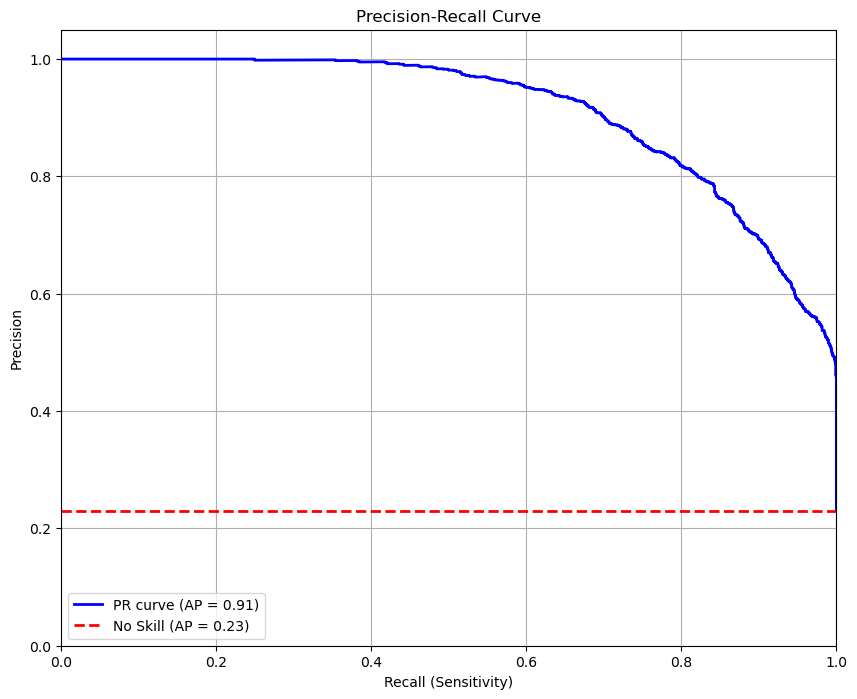

In [22]:
# Define the path to save the image
output_path = os.path.join(os.getcwd(), '..', 'images', 'PR-AUC.png')

#Calculate Precision-Recall Curve Metrics
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Precision-Recall AUC (Average Precision): {average_precision:.4f}")

#Plot Precision-Recall Curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
no_skill = len(y_test[y_test==1]) / len(y_test) # Calculate and plot the no-skill line (predicting the positive class based on its prevalence)
plt.plot([0, 1], [no_skill, no_skill], color='red', lw=2, linestyle='--', label=f'No Skill (AP = {no_skill:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left") # Often better to put legend here for PR curves
plt.grid(True)
# Save the plot
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()